<a href="https://colab.research.google.com/github/KasraOstad/Vineyard-Classification-in-Sussex/blob/master/vineyard_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Notebook was used to conduct the machine learning classification 

In [ ]:
from collections import Counter
from datetime import datetime as dt
import earthpy as et
import ee 
import folium
import geehydro
import geopandas as gpd
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from imblearn.over_sampling import SVMSMOTE, SMOTE
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import time

C:\Users\aghaj\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#import gov CROME 2019 data
CROME_roi= gpd.read_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\ROI_2019CROME.shp')

#import sentinel 1 data
s1_extracted=gpd.read_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\extracted_shp\s1\2polygons_all.shp')



In [ ]:
#import sentinel 2 data

s2_extracted1=gpd.read_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\extracted_shp\s2_batch1\s2_batch1\2polygons_all.shp')
s2_extracted2=gpd.read_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\extracted_shp\s2_batch2\s2_batch2\2polygons_all.shp')
s2_extracted3=gpd.read_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\extracted_shp\s2_batch3\s2_batch3\2polygons_all.shp')
s2_extracted4=gpd.read_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\extracted_shp\s2_batch4\s2_batch4\2polygons_all.shp')
s2_extracted5=gpd.read_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\extracted_shp\s2_batch5\s2_batch5\2polygons_all.shp')
s2_extracted6=gpd.read_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\extracted_shp\s2_batch6\s2_batch6\2polygons_all.shp')

#import multi temporal sentinel 1
s1_extracted2=gpd.read_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\extracted_shp\s1_extraction2\2polygons_all.shp')
s1_extracted3=gpd.read_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\extracted_shp\s1_extraction4\2polygons_all.shp')

In [ ]:
#import vegetation indicies data

veg1=gpd.read_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\extracted_shp\veg_index1\veg_index1\2polygons_all.shp')
veg2=gpd.read_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\extracted_shp\veg_index2\veg_index2\2polygons_all.shp')


In [ ]:
#Sort extracted data to have same polygon order
def sort_extracted_data(df):
    df=df.sort_values('id')
    df=df.set_index('id')
    return df
 
s1_extracted=sort_extracted_data(s1_extracted)

s2_extracted1=sort_extracted_data(s2_extracted1)
s2_extracted2=sort_extracted_data(s2_extracted2)
s2_extracted3=sort_extracted_data(s2_extracted3)
s2_extracted4=sort_extracted_data(s2_extracted4)
s2_extracted5=sort_extracted_data(s2_extracted5)
s2_extracted6=sort_extracted_data(s2_extracted6)

veg1=sort_extracted_data(veg1)
veg2=sort_extracted_data(veg2)

s1_extracted2=sort_extracted_data(s1_extracted2)
s1_extracted3=sort_extracted_data(s1_extracted3)


In [ ]:
def xycentroid(df):
    df['centroid']=df['geometry'].centroid

    centroid_list=df['centroid'].tolist()

    x_centroid=[]
    y_centroid=[]

    for cent in centroid_list:
        split=str(cent).split()
        x=split[1]
        y=split[2]
        x_centroid.append(float(x.split('(')[1]))
        y_centroid.append(float(y.split(')')[0]))


    df['x_centroid']=x_centroid
    df['y_centroid']=y_centroid
    
    return df

#Combine all sentinel bands together 
CROME_geometry=CROME_roi['geometry'].to_list()
all_bands=gpd.GeoDataFrame(data=CROME_geometry,columns=['geometry'])
all_bands['lucode']=CROME_roi['lucode']
all_bands=xycentroid(all_bands)
all_bands=all_bands.round({'y_centroid':6,'x_centroid':6})

all_bands['VV']=s1_extracted['VV']
all_bands['VH']=s1_extracted['VH']

all_bands['VV2']=s1_extracted2['VV']
all_bands['VH2']=s1_extracted2['VH']

all_bands['VV3']=s1_extracted3['VV']
all_bands['VH3']=s1_extracted3['VH']

all_bands['B1']=s2_extracted1['B1']
all_bands['B2']=s2_extracted1['B2']

all_bands['B3']=s2_extracted2['B3']
all_bands['B4']=s2_extracted2['B4']

all_bands['B5']=s2_extracted3['B5']
all_bands['B6']=s2_extracted3['B6']

all_bands['B7']=s2_extracted4['B7']
all_bands['B8']=s2_extracted4['B8']

all_bands['B8A']=s2_extracted5['B8A']
all_bands['B9']=s2_extracted5['B9']

all_bands['B11']=s2_extracted6['B11']
all_bands['B12']=s2_extracted6['B12']
all_bands['QA60']=s2_extracted6['QA60']

all_bands['NDVI']=veg1['NDVI']
all_bands['NDWI']=veg1['NDWI']

all_bands['CL']=veg2['CL']
all_bands['EVI2']=veg2['EVI2']



all_bands.head()

,geometry,lucode,centroid,x_centroid,y_centroid,VV,VH,VV2,VH2,VV3,...,B8,B8A,B9,B11,B12,QA60,NDVI,NDWI,CL,EVI2
0,"POLYGON ((0.02825 51.02273, 0.02768 51.02274, ...",WO12,POINT (0.02798 51.02304),0.027978,51.023044,-8.045135,-14.201860,-9.427401,-17.841309,-9.065287,...,3562.0,3719.0,3563.0,1452.0,610.0,0.0,0.867097,0.410485,3.790984,1.982652
1,"POLYGON ((-0.06525 50.87290, -0.06582 50.87291...",AC67,POINT (-0.06552 50.87322),-0.065521,50.873221,-8.386858,-17.493228,-13.552281,-17.690492,-8.216926,...,3906.0,4105.0,4167.0,2890.0,1632.0,0.0,0.632236,0.153755,0.823475,1.256790
2,"POLYGON ((0.16364 51.04553, 0.16307 51.04554, ...",NA01,POINT (0.16337 51.04585),0.163367,51.045850,-7.624910,-16.759073,-8.755340,-16.899974,-6.163937,...,1794.0,1912.0,2038.0,1460.0,1150.0,0.0,0.450271,0.094552,0.886812,0.812610
3,"POLYGON ((0.15901 50.82909, 0.15958 50.82908, ...",PG01,POINT (0.15928 50.82878),0.159279,50.828776,-13.440635,-21.766196,-12.521662,-20.505736,-11.589647,...,3436.0,3694.0,3571.0,2533.0,1411.0,0.0,0.636528,0.134567,1.451495,1.268331
4,"POLYGON ((0.10526 51.09208, 0.10583 51.09207, ...",PG01,POINT (0.10553 51.09177),0.105529,51.091768,-13.302950,-18.204413,-11.770360,-19.077879,-11.338653,...,3580.0,3795.0,3778.0,2038.0,1039.0,0.0,0.814036,0.239939,2.179946,1.800282


In [ ]:
def ground_truth_allign(df):
    x_centroids=df['x_centroid'].to_list()
    y_centroids=df['y_centroid'].to_list()
    
    ground_data=[]
    
    for i in range(0,len(x_centroids)):
        x_centroids[i]=round(x_centroids[i],6)
        y_centroids[i]=round(y_centroids[i],6)
       
        match=all_bands[all_bands['y_centroid']==y_centroids[i]]
        match=match[match['x_centroid']==x_centroids[i]]
        ground_data.append(match)
        
    
    ground_data=pd.concat(ground_data)
        
    return ground_data
    

#import ground truth labels for grass and vineyard polygons
vineyard_polygons=gpd.read_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\ground_truth\vineyard_polygons2.shp')
vineyard_polygons=xycentroid(vineyard_polygons)

vineyard_data=ground_truth_allign(vineyard_polygons)
vineyard_data['label']=1
vineyard_data['bin_label']=1

#Find how the CROME set mislabelled vineyards in our ground truth labels
vineyard_mislabel=vineyard_data['lucode'].to_list()
Counter(vineyard_mislabel)


Counter({'PG01': 102, 'AC44': 9, 'FA01': 8, 'AC17': 8, 'TC01': 7})

Text(0, 0.5, 'Frequency')

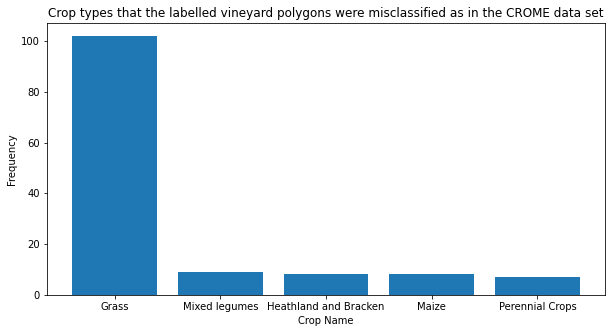

In [ ]:
#Plot the crops our vineyard polygons are missclassifed as

vineyard_mislabel
vineyard_mislabel_names=[]
for luc in vineyard_mislabel:
    if luc == 'PG01':
        vineyard_mislabel_names.append('Grass')
    if luc =='AC44':
        vineyard_mislabel_names.append('Mixed legumes')
    if luc =='FA01':
        vineyard_mislabel_names.append('Heathland and Bracken')
    if luc =='AC17':
        vineyard_mislabel_names.append('Maize')
    if luc =='TC01':
        vineyard_mislabel_names.append('Perennial Crops')
                                       
        
counts=dict(Counter(vineyard_mislabel_names))
keys = counts. keys()
values = counts. values()
plt.figure(figsize=(10,5)) 
plt.bar(keys, values)

plt.title('Crop types that the labelled vineyard polygons were misclassified as in the CROME data set')
plt.xlabel('Crop Name')
plt.ylabel('Frequency')

In [ ]:
#Remove vineyard data from all data so they dont get sampled during creation of training set
all_bands.drop(vineyard_data.index, axis=0,inplace=True)


Text(0, 0.5, 'Percentage of study area')

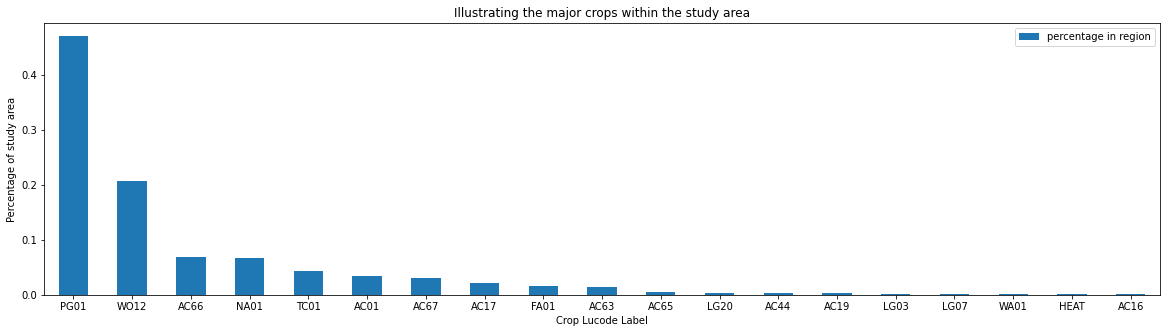

In [ ]:
#Find Crop distibution from CROME data set for our region

count_df=CROME_roi.groupby('lucode').count()

lucode=count_df.index.tolist()
lucode_count=count_df['geometry'].to_list()
lucode_percent=[]

for c in lucode_count:
    lucode_percent.append(c/987720)
    
lucode_df=pd.DataFrame(data=lucode,columns=['lucode'])

lucode_df['percentage in region']=lucode_percent
lucode_df['lucode_count']=lucode_count

lucode_names=['Spring Barley','Beet','Spring Linseed','Maize','Spring Oats','Onions','Spring Wheat','Potato','Mixed legumes','Winter Barley','Winter Oats','Winter Wheat','Winter Oilseed','Winter Rye','Winter Triticale','Fallow Land','Heathland and Bracken','Heather','Spring Field beans','Spring Peas','Soya','Lucerne','Winter Field beans','Non-vegetated or sparsely-vegetated Land','Nursery Crops','Grass','Perennial Crops and Isolated Trees','Water','Trees and Scrubs, short Woody plants, hedgerows']
lucode_df['Name']=lucode_names

#Indicate number of samples for each crop for training set
lucode_df['Initial Polygon Number']=(round(lucode_df['lucode_count']/100)*1).astype(int)

luc_df=lucode_df.sort_values('percentage in region',ascending=False)
luc_df=luc_df[luc_df['Initial Polygon Number']>4]
ax = luc_df.plot.bar(x='lucode', y='percentage in region', rot=0,figsize=(20,5),title='Illustrating the major crops within the study area')
ax.set_xlabel("Crop Lucode Label")
ax.set_ylabel("Percentage of study area")

C:\Users\aghaj\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


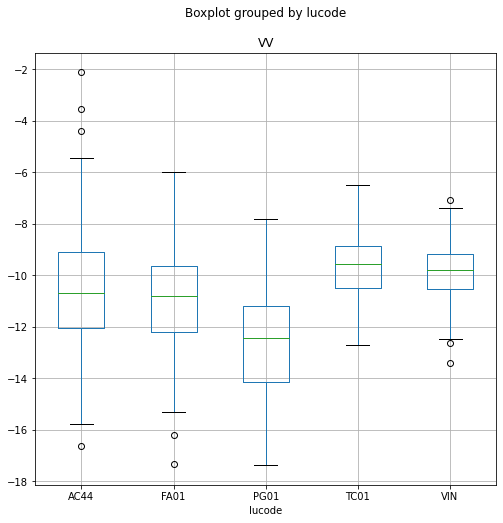

In [ ]:
#Compare sentinel 1 band for crops that were misclassified as vineyard in CROME and vineyard

mislabeled_crops=lucode_df.loc[[25,26,8,16]]
mislabeled_crops_lucode=mislabeled_crops['lucode'].to_list()

mislabeled_crops_samples=[]

for i in range(0,len(mislabeled_crops_lucode)):
    crop_df=all_bands[all_bands['lucode']==mislabeled_crops_lucode[i]]
    crop_sample=crop_df.sample(n=126,replace=False,random_state=0)
    mislabeled_crops_samples.append(crop_sample)

vineyard_sample=vineyard_data
vineyard_sample['lucode']='VIN'
mislabeled_crops_samples.append(vineyard_sample)

compare_mislabeled=pd.concat(mislabeled_crops_samples)
compare_mislabeled=compare_mislabeled.drop(columns=['geometry','centroid','x_centroid','y_centroid'])
compare_mislabeled=compare_mislabeled.set_index('lucode')
compare_mislabeled.boxplot(column=['VV'], by='lucode',figsize=(8,8),title='')

In [ ]:
grass_df=all_bands[all_bands['lucode']=='PG01']

#Filter to have less chance of sampling vineyard in grass training samples
grass_df1=grass_df[grass_df['VV']<-12]
grass_data1=grass_df1.sample(n=25000, replace=False, random_state=1)
grass_data1['label']=0
grass_data1['bin_label']=0

grass_df2=grass_df[grass_df['VV']>-12]
grass_data2=grass_df2.sample(n=100, replace=False, random_state=1)
grass_data2['label']=0
grass_data2['bin_label']=0


In [ ]:
#Build training, validation and test set

majority_crops=lucode_df[lucode_df['Initial Polygon Number']>4]

majority_crops=majority_crops.set_index('lucode')
majority_crops=majority_crops.drop(index='PG01')

majority_crop_names=list(majority_crops.index.values)
majority_crop_ss=majority_crops['Initial Polygon Number'].to_list()

training=[]

label_lucode=[]


for i in range(0,len(majority_crop_names)):
    crop_df=all_bands[all_bands['lucode']==majority_crop_names[i]]
    
    if majority_crop_names[i]=='TC01':
        crop_sample=crop_df.sample(n=200,replace=False,random_state=1)
    elif majority_crop_names[i]=='AC17':
        crop_sample=crop_df.sample(n=450,replace=False,random_state=1)
    elif majority_crop_names[i]=='WO12':
        crop_sample=crop_df.sample(n=1000,replace=False,random_state=1)
    elif majority_crop_names[i]=='NA01':
        crop_sample=crop_df.sample(n=100,replace=False,random_state=1)
    elif majority_crop_names[i]=='FA01':
        crop_sample=crop_df.sample(n=260,replace=False,random_state=1)
    elif majority_crop_names[i]=='AC67':
        crop_sample=crop_df.sample(n=400,replace=False,random_state=1)
    elif majority_crop_ss[i]>100:
        crop_sample=crop_df.sample(n=round(majority_crop_ss[i]),replace=False,random_state=1)
    else:
        crop_sample=crop_df.sample(n=130,replace=False,random_state=1)
            
    crop_sample['label']=i+2
    crop_sample['bin_label']=0
    training.append(crop_sample)
    label_lucode.append((majority_crop_names[i],i+2))

        
 
training.append(grass_data1)
training.append(grass_data2)

training=pd.concat(training) 
training=training.drop(columns=['QA60','lucode','x_centroid','y_centroid','geometry','centroid'])

test=all_bands.copy()
test.drop(training.index, axis=0,inplace=True)
test_x=test['x_centroid'].to_list()
test_y=test['y_centroid'].to_list()
test_geometry=test['geometry'].to_list()
test_lucode=test['lucode'].to_list()
test=test.drop(columns=['QA60','lucode','x_centroid','y_centroid','geometry','centroid'])


if 'QA60' in vineyard_data.columns:
    vineyard_data=vineyard_data.drop(columns=['QA60','lucode','x_centroid','y_centroid','geometry','centroid'])

training=[training,vineyard_data]
training=pd.concat(training)


validation=[]

for i in range(0,len(majority_crop_names)+2):
    crop_train=training[training['label']==i]
    validation.append(crop_train.sample(frac=0.2, replace=False, random_state=1))

validation=pd.concat(validation)
validation=validation.sort_index()
training=training.drop(validation.index)

training_labels=training['label'].to_list()
training_binlabels=training['bin_label'].to_list()
training=training.drop(columns=['bin_label'])

validation_labels=validation['label'].to_list()
validation=validation.drop(columns=['label'])

validation_binlabels=validation['bin_label'].to_list()
validation=validation.drop(columns=['bin_label'])

training.head()

,VV,VH,VV2,VH2,VV3,VH3,B1,B2,B3,B4,...,B8,B8A,B9,B11,B12,NDVI,NDWI,CL,EVI2,label
248846,-10.841436,-20.487769,-12.302515,-21.563280,-14.582198,-23.901198,622.0,1032.0,1424.0,2144.0,...,3150.0,3440.0,3435.0,4721.0,3435.0,0.191896,-0.199500,0.178571,0.306374,2
837000,-9.707769,-19.466829,-13.837893,-23.079713,-13.536223,-20.032859,398.0,689.0,910.0,1246.0,...,1892.0,2025.0,2425.0,2886.0,2099.0,0.197035,-0.208037,0.230769,0.315280,2
322792,-9.940770,-19.024180,-13.743224,-22.923950,-13.944270,-21.192507,514.0,762.0,1058.0,1510.0,...,2050.0,2144.0,2103.0,3063.0,2757.0,0.154279,-0.203558,0.150610,0.242229,2
413980,-11.988274,-23.433823,-10.869657,-19.510139,-13.425539,-21.101836,448.0,737.0,984.0,1300.0,...,1990.0,2129.0,2636.0,2960.0,2282.0,0.213018,-0.198860,0.223464,0.343315,2
849294,-8.206162,-15.774319,-13.117466,-19.728694,-13.932798,-20.000926,433.0,577.0,828.0,1076.0,...,2456.0,2705.0,2826.0,2312.0,1513.0,0.466269,0.017842,0.841030,0.848433,2


In [ ]:
#Create table of to compare inital and improved class distributions in training set

crop_distribution=lucode_df[lucode_df['Initial Polygon Number']>4]
crop_distribution=crop_distribution.drop(columns=['percentage in region','lucode_count'])
model_label=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,0,17,18,19]
improved_sample=[345,130,450,130,130,142,130,672,400,260,130,130,130,130,100,25100,200,130,1000]
crop_distribution['Improved Polygon Number']=improved_sample
crop_distribution['Model Label']=model_label
crop_distribution=crop_distribution[['Name','lucode','Model Label','Initial Polygon Number','Improved Polygon Number']]
vin_row = {'Name':'Vineyard', 'Model Label':1, 'Initial Polygon Number':134, 'Improved Polygon Number':134}
crop_distribution=crop_distribution.append(vin_row,ignore_index=True)
crop_distribution['Polygon Delta'] = crop_distribution['Improved Polygon Number'].sub(crop_distribution['Initial Polygon Number'], axis = 0) 
crop_distribution=crop_distribution.set_index('Name')
crop_distribution=crop_distribution.sort_values(by=['Model Label'])
crop_distribution

,lucode,Model Label,Initial Polygon Number,Improved Polygon Number,Polygon Delta
Name,,,,,
Grass,PG01,0,4658,25100,20442
Vineyard,NaN,1,134,134,0
Spring Barley,AC01,2,345,345,0
Spring Linseed,AC16,3,5,130,125
Maize,AC17,4,221,450,229
Spring Oats,AC19,5,35,130,95
Mixed legumes,AC44,6,37,130,93
Winter Oats,AC63,7,142,142,0
Winter Wheat,AC65,8,49,130,81


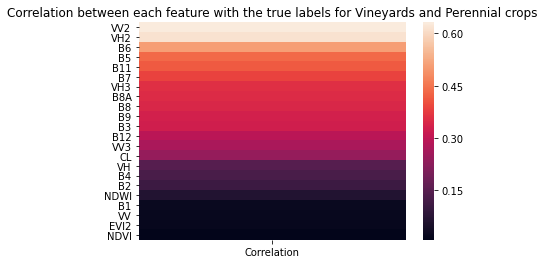

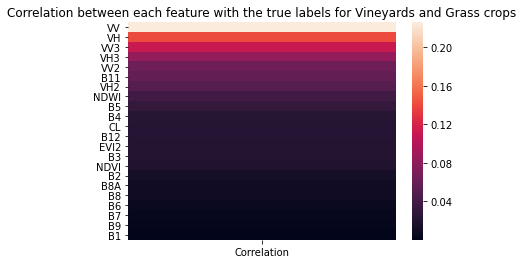

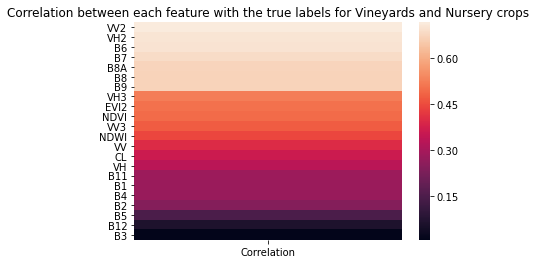

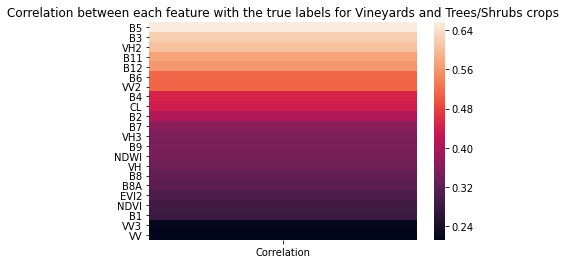

In [ ]:
#Find correlation between the features

def feature_heatmap(luc,name):
    vineyard_df=vineyard_data.drop(columns=['label'])
    crop_df=training[training['label']==luc]
    #crop_df=crop_df.drop(columns=['geometry','centroid','x_centroid','y_centroid','lucode','QA60'])
    #crop_df['bin_label']=0
    
    vin_df=training[training['label']==1]
    
    correlation_df=pd.concat([vin_df,crop_df])
    cor=correlation_df.corr()
    cor=cor.drop(['label'])
    cor=abs(cor.loc[:, ['label']])
    cor=cor.rename(columns={"label": "Correlation"})
    cor=cor.sort_values(by=['Correlation'],ascending=False)
    
    ax = plt.axes()
    sns.heatmap(cor, ax = ax,xticklabels=True, yticklabels=True)

    ax.set_title('Correlation between each feature with the true labels for Vineyards and '+name+' crops' )
    
    return plt.show()



feature_heatmap(17,'Perennial')
feature_heatmap(0,'Grass')
feature_heatmap(16,'Nursery')
feature_heatmap(19,'Trees/Shrubs')

Text(0.5, 1.0, 'Correlation between each feature with the true labels for all crop classes')

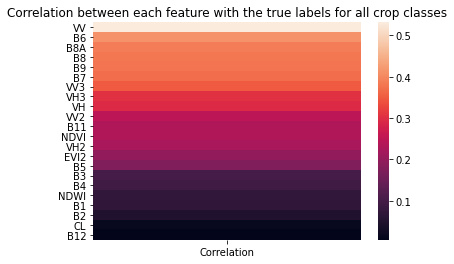

In [ ]:
#Find correlation between the features
cor=training.corr()

cor=cor.drop(['label'])
cor=abs(cor.loc[:, ['label']])
cor=cor.rename(columns={"label": "Correlation"})
cor=cor.sort_values(by=['Correlation'],ascending=False)

figsize=(16,5)
ax = plt.axes()

sns.heatmap(cor, ax = ax,xticklabels=True, yticklabels=True)
ax.set_title('Correlation between each feature with the true labels for all crop classes' )


In [ ]:
#Scenario based Feature Selection

s1_bands=['VV','VH']
s1_bands2=['VV2','VH2']
s1_bands3=['VV3','VH3']
s2_bands=['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
veg_bands=['NDVI','NDWI','EVI2','CL']

combination=s1_bands+s1_bands2+s2_bands+veg_bands

train_labels=training['label'].to_list()

s2_training=training.reindex(columns=combination)
s2_validation=validation.reindex(columns=combination)
s2_training



,VV,VH,VV2,VH2,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI,NDWI,EVI2,CL
248846,-10.841436,-20.487769,-12.302515,-21.563280,622.0,1032.0,1424.0,2144.0,2545.0,2687.0,2987.0,3150.0,3440.0,3435.0,4721.0,3435.0,0.191896,-0.199500,0.306374,0.178571
837000,-9.707769,-19.466829,-13.837893,-23.079713,398.0,689.0,910.0,1246.0,1467.0,1609.0,1824.0,1892.0,2025.0,2425.0,2886.0,2099.0,0.197035,-0.208037,0.315280,0.230769
322792,-9.940770,-19.024180,-13.743224,-22.923950,514.0,762.0,1058.0,1510.0,1744.0,1825.0,1990.0,2050.0,2144.0,2103.0,3063.0,2757.0,0.154279,-0.203558,0.242229,0.150610
413980,-11.988274,-23.433823,-10.869657,-19.510139,448.0,737.0,984.0,1300.0,1597.0,1731.0,1916.0,1990.0,2129.0,2636.0,2960.0,2282.0,0.213018,-0.198860,0.343315,0.223464
849294,-8.206162,-15.774319,-13.117466,-19.728694,433.0,577.0,828.0,1076.0,1321.0,2056.0,2380.0,2456.0,2705.0,2826.0,2312.0,1513.0,0.466269,0.017842,0.848433,0.841030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472553,-10.799664,-17.056675,-11.288454,-18.008665,428.0,508.0,827.0,711.0,1409.0,2888.0,3390.0,3592.0,3785.0,3784.0,2875.0,1769.0,0.668222,0.109794,1.355444,1.404542
546099,-9.971716,-19.357401,-8.972102,-19.123122,639.0,1214.0,1596.0,1800.0,2127.0,2942.0,3226.0,3249.0,3391.0,3301.0,3327.0,2708.0,0.278798,-0.033128,0.463104,0.387097
483153,-9.725297,-16.891090,-12.953132,-18.877687,216.0,313.0,607.0,316.0,1020.0,2925.0,3480.0,3494.0,3691.0,3716.0,2041.0,964.0,0.833333,0.260547,1.865223,2.408243
160640,-10.965927,-16.347836,-10.556168,-17.906534,336.0,417.0,649.0,452.0,1076.0,2685.0,3259.0,3284.0,3578.0,3695.0,1977.0,997.0,0.760168,0.241678,1.626870,1.878097


In [ ]:
#Train Classifier and predict validation set

#Random Forest test
def classification(train,labels,test,classifier,p1,p2,p3,p4):
    
    #Support vector Machine
    if classifier=='svm':
        svclassifier = SVC(kernel=p1,gamma=p2,C=p3,random_state=1) #define svm
        svclassifier.fit(train, labels)        #train svm
        testPredict=svclassifier.predict(test)         #apply svm 

    #Random Forest
    if classifier=='rf':
        rfclassifier=RandomForestClassifier(n_estimators=p1,max_samples=p2,max_features=p3,max_depth=p4,random_state=8) #define rf
        rfclassifier.fit(train,labels) #train rf
        testPredict=rfclassifier.predict(test) #apply rf
        
    #Multi Layer Perceptron 
    if classifier=='mlp':
        mlpclassifier=MLPClassifier(solver=p1, alpha=p2, hidden_layer_sizes=p3, random_state=1)
        mlpclassifier.fit(train, labels)
        testPredict=mlpclassifier.predict(test)
        
    return testPredict

def print_accuracy(true_label,v_prediction):
    print('Accuracy score in validation: '+ str(accuracy_score(true_label,v_prediction)))
    print('F1 score in validation: '+ str(f1_score(true_label,v_prediction)))
    print('Recall score in validation: '+ str(recall_score(true_label,v_prediction)))
    print('Precision score in validation: '+ str(precision_score(true_label,v_prediction)))
    return 0

def accuracy_measure(y_actual,y_predict):
    TP=0
    FP=0
    TN=0
    FN=0
    
    for i in range(len(y_actual)):
        if y_actual[i]==y_predict[i]==1:
            TP+=1
        if y_predict[i]==1 and y_actual[i]!=y_predict[i]:
            FP += 1
        if y_actual[i]==y_predict[i]==0:
            TN += 1
        if y_predict[i]==0 and y_actual[i]!=y_predict[i]:
            FN += 1

    return(TP, FP, TN, FN)

def bin_classification(predictions):
    predict_bin=[]
    for pred in predictions:
        if pred == 1.0:
            predict_bin.append(1)
        else:
            predict_bin.append(0)
    return predict_bin



scaler = StandardScaler()
training_scale=scaler.fit_transform(s2_training)
validation_scale=scaler.transform(s2_validation)

starttime=time.time()
validate_predict=classification(training_scale,train_labels,validation_scale,'svm','rbf','scale',500,None)
#validate_predict=classification(training_scale,train_labels,validation_scale,'rf',100,None,11,None)
endtime=time.time()
print(endtime-starttime)

validate_predict_bin=bin_classification(validate_predict)
print_accuracy(validation_binlabels,validate_predict_bin)

print('(TP,FP,TN,FN):')
print(accuracy_measure(validation_binlabels,validate_predict_bin))


13.648486137390137
Accuracy score in validation: 0.997997997997998
F1 score in validation: 0.7857142857142857
Recall score in validation: 0.8148148148148148
Precision score in validation: 0.7586206896551724
(TP,FP,TN,FN):
(22, 7, 5960, 5)


Text(0, 0.5, 'Number of False Positives')

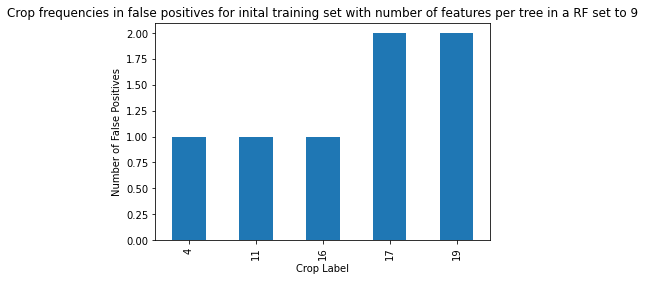

In [ ]:
#Display False Positives

false_positives=pd.DataFrame(data=validation_scale,columns=s2_training.columns)
false_positives['bin_prediction']=validate_predict_bin
false_positives['crop_label']=validation_labels
false_positives['bin_label']=validation_binlabels
false_positives=false_positives[false_positives['bin_prediction']==1]
false_positives=false_positives[false_positives['crop_label']!=1]
ax=false_positives.groupby(['crop_label']).count()['B1'].plot.bar(title='Crop frequencies in false positives for inital training set with number of features per tree in a RF set to 9')
ax.set_xlabel("Crop Label")
ax.set_ylabel("Number of False Positives")


Text(0, 0.5, 'Number of False Negatives')

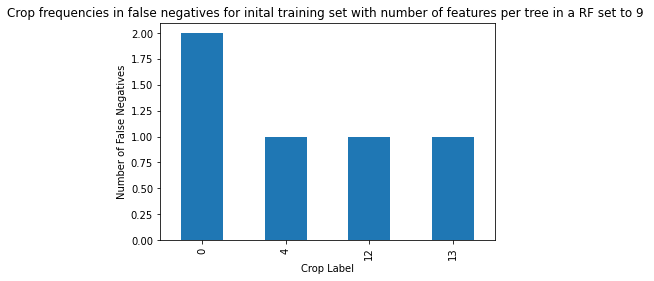

In [ ]:
#Display False Negatives
false_negatives=pd.DataFrame(data=validation_scale,columns=s2_training.columns)
false_negatives['bin_prediction']=validate_predict_bin
false_negatives['prediction']=validate_predict
false_negatives['crop_label']=validation_labels
false_negatives['bin_label']=validation_binlabels
false_negatives=false_negatives[false_negatives['bin_prediction']==0]
false_negatives=false_negatives[false_negatives['crop_label']==1]
ax=false_negatives.groupby(['prediction']).count()['B1'].plot.bar(title='Crop frequencies in false negatives for inital training set with number of features per tree in a RF set to 9 ')
ax.set_xlabel("Crop Label")
ax.set_ylabel("Number of False Negatives")


In [ ]:
#Tune Regularisation parameter in SVM
def C_selection(train,train_labels,C_range,val):
    F1_scores=[]
    recall_scores=[]
    precision_scores=[]
    
    for i in C_range:
        predict=classification(train,train_labels,val,'svm','rbf','scale',i,None)
        predict_bin=bin_classification(predict)
        F1_scores.append(f1_score(validation_binlabels,predict_bin))
        recall_scores.append(recall_score(validation_binlabels,predict_bin))
        precision_scores.append(precision_score(validation_binlabels,predict_bin))

    C_analysis=pd.DataFrame(data=C_range,columns=['C'])
    C_analysis['F1 Score']=F1_scores
    C_analysis['Recall Score']=recall_scores
    C_analysis['Precision Score']=precision_scores
    return C_analysis

scaler = StandardScaler()
training_scale=scaler.fit_transform(s2_training)
validation_scale=scaler.transform(s2_validation)

#Find optimum C for a broad range of values
C_range=np.arange(1, 1100, 100)

starttime=time.time()
full_range=C_selection(training_scale,train_labels,C_range,validation_scale)
endtime=time.time()
seconds=endtime-starttime

print(seconds)

134.4072835445404


501.0


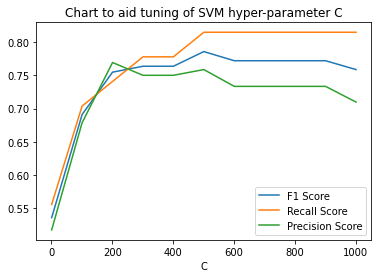

In [ ]:
#Display tuning of SVM regularisation parameter

def SVM_vis(df,col,metric):
    df=df.set_index('C')
    df.plot.line(title='Chart to aid tuning of SVM hyper-parameter C') 




max_accuracy_index=full_range['F1 Score'].idxmax()
C=full_range.iloc[max_accuracy_index]['C']
print(C)

#Visualise optimum C
SVM_vis(full_range,'b','f1')


863.4821569919586


Text(0, 0.5, 'Accuracy')

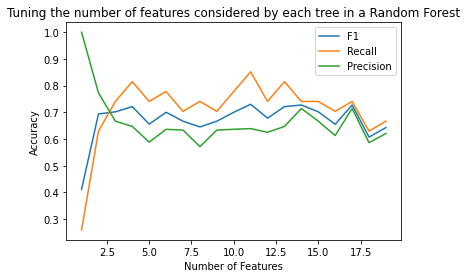

In [ ]:
#Tune Random Forest
def tune_RF(parameter,feature_number,max_samples,estimators):
    F1_scores=[]
    recall_scores=[]
    precision_scores=[]
    if parameter=='feature_subset':
        for i in feature_number:
            validate_predict=classification(training_scale,train_labels,validation_scale,'rf',estimators,None,i,None)
            validate_predict_bin=bin_classification(validate_predict)
            F1_scores.append(f1_score(validation_binlabels,validate_predict_bin))
            recall_scores.append(recall_score(validation_binlabels,validate_predict_bin))
            precision_scores.append(precision_score(validation_binlabels,validate_predict_bin))
            
    if parameter=='max_sample':
        for i in max_samples:
            validate_predict=classification(training_scale,train_labels,validation_scale,'rf',estimators,i,feature_number,None)
            validate_predict_bin=bin_classification(validate_predict)
            F1_scores.append(f1_score(validation_binlabels,validate_predict_bin))
            recall_scores.append(recall_score(validation_binlabels,validate_predict_bin))
            precision_scores.append(precision_score(validation_binlabels,validate_predict_bin))
            
    if parameter=='estimators':
        for i in estimators:
            validate_predict=classification(training_scale,train_labels,validation_scale,'rf',i,max_samples,feature_number,None)
            validate_predict_bin=bin_classification(validate_predict)
            F1_scores.append(f1_score(validation_binlabels,validate_predict_bin))
            recall_scores.append(recall_score(validation_binlabels,validate_predict_bin))
            precision_scores.append(precision_score(validation_binlabels,validate_predict_bin))
    
    return F1_scores,recall_scores,precision_scores



scaler = StandardScaler()
training_scale=scaler.fit_transform(s2_training)
validation_scale=scaler.transform(s2_validation)

feature_number=np.arange(1,len(s2_training.columns), 1)

max_samples=np.arange(0.1,1, 0.1)
max_samples=max_samples.tolist()
max_samples.append(None)



starttime=time.time()
optimum_features,feature_completeness,feature_purity=tune_RF('feature_subset',feature_number,max_samples,100)    
endtime=time.time()
print(endtime-starttime)


plt.plot(feature_number, optimum_features,label='F1')
plt.plot(feature_number, feature_completeness, label='Recall')
plt.plot(feature_number, feature_purity, label='Precision')

plt.legend()
plt.title('Tuning the number of features considered by each tree in a Random Forest')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Seconds')

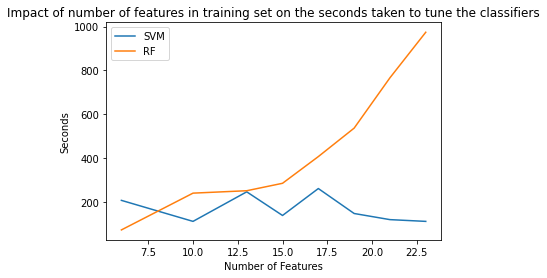

In [ ]:
#Plot time taken to tune classifiers as number of features increased
f=[6,10,13,15,17,19,21,23]
svm_times=[206,110,245,137,260,146,118,110]
rf_times=[71,239,250,284,406,536,766,974]

plt.plot(f, svm_times,label='SVM')
plt.plot(f, rf_times, label='RF')

plt.legend()
plt.title('Impact of number of features in training set on the seconds taken to tune the classifiers')
plt.xlabel('Number of Features')
plt.ylabel('Seconds')


In [ ]:
#Implement model on the rest of study area

test_scale=scaler.transform(test.reindex(columns=combination))

#test_predict=classification(training_scale,train_labels,test_scale,'rf',100,None,11,None)
test_predict=classification(training_scale,train_labels,test_scale,'svm','rbf','scale',500,None)

#Find number of predictions for each crop
print(Counter(test_predict))

#Find CROME label for vineyard predictions
test_diag=pd.DataFrame(data=test_lucode,columns=['lucode'])
test_diag['prediction']=test_predict
test_diag=test_diag[test_diag['prediction']==1.0]
test_diag_lucode=test_diag['lucode'].to_list()

Counter(test_diag_lucode)

Counter({0: 401520, 19: 218300, 9: 58439, 17: 43371, 4: 37281, 16: 34649, 10: 34381, 11: 26447, 2: 26410, 1: 17764, 15: 12094, 7: 11541, 12: 7338, 6: 7109, 8: 6534, 5: 4320, 13: 3803, 14: 3692, 3: 2035, 18: 842})


Counter({'PG01': 14210,
         'TC01': 960,
         'AC17': 442,
         'WO12': 785,
         'NA01': 500,
         'AC44': 65,
         'FA01': 331,
         'AC19': 3,
         'AC65': 3,
         'LG03': 22,
         'LG20': 70,
         'AC66': 29,
         'AC63': 13,
         'AC67': 288,
         'AC01': 27,
         'LG07': 5,
         'HEAT': 6,
         'AC68': 2,
         'AC03': 2,
         'AC32': 1})

In [ ]:
#Define locations of vineyard predictions
test_locations=gpd.GeoDataFrame(data=test_predict,columns=['prediction'])
test_locations['geometry']=test_geometry

for band in test.columns:
    test_locations[band]=test[band]


test_locations=test_locations[test_locations['prediction']==1]
test_locations.head()

,prediction,geometry,VV,VH,VV2,VH2,VV3,VH3,B1,B2,...,B7,B8,B8A,B9,B11,B12,NDVI,NDWI,CL,EVI2
56,1,"POLYGON ((0.18299 51.07477, 0.18242 51.07478, ...",-9.914114,-14.532241,-8.170285,-15.762836,-7.047713,-17.346952,599.0,705.0,...,3059.0,3240.0,3365.0,3491.0,2495.0,1557.0,0.568000,0.136476,1.314062,1.090056
117,1,"POLYGON ((-0.11767 50.91956, -0.11796 50.91925...",-7.087349,-15.436030,-7.680446,-16.708476,-10.215086,-14.210382,245.0,257.0,...,2830.0,3024.0,3241.0,3314.0,1420.0,568.0,0.861982,0.363693,3.768908,1.964541
128,1,"POLYGON ((0.06422 50.92708, 0.06365 50.92709, ...",-11.053832,-20.642569,-15.969557,-24.588641,-16.872452,-27.044372,983.0,1262.0,...,2797.0,3020.0,3013.0,4155.0,2933.0,2343.0,0.333932,0.016720,0.449153,0.569277
155,1,"POLYGON ((0.17270 51.00144, 0.17213 51.00145, ...",-12.856968,-16.788262,-11.011479,-18.131050,-10.693764,-17.383436,304.0,370.0,...,3047.0,3234.0,3394.0,3372.0,1886.0,883.0,0.804714,0.297579,2.316554,1.769443
162,1,"POLYGON ((0.14360 50.87081, 0.14303 50.87082, ...",-8.609172,-15.209070,-11.047443,-17.503116,-9.961735,-16.151270,278.0,381.0,...,2955.0,3130.0,3347.0,3559.0,1311.0,549.0,0.838212,0.414526,3.498457,1.881819


In [ ]:
import random

#Load google earth extracted data set of 750 random vineyard points
vineyard_points_df=gpd.read_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\vin_rp2\random_points.shp')
vineyard_points_df=vineyard_points_df.reindex(columns=['B2','B3','B4','B5','B6','B7','VV','VH'])

random.seed(0)

#Bootstrap 95% confidence intervals for the median of each feature

#Takes a sample from the given list
def bootstrap_sample( a_huge_key_list ) :
    L = len(a_huge_key_list) 
    i = np.random.randint(0, L)
    return a_huge_key_list[i]

#Calls sampling for a given, taking the median and returning a list of medians
def bootstrap_loop(data,n=1000):
    bsmedian=[]
    for i in range(n):
        bs=bootstrap_sample(np.array(data))
        bsmedian.append(np.median(bs))
    return bsmedian

#Calculates mean and confidence interval for given list of medians
def bootstrap_print(median_array,band):
    print ('Boostrap for '+band+' :')
    print ("CI=({},{})".format('%.3f'%(np.percentile(median_array,2.5)),'%.3f'%(np.percentile(median_array,97.5))))
    print('')

    
def filter_classification(df,bands,lower_threshold,upper_threshold):
    for i in range(0,len(bands)):
        df=df[df[bands[i]]>lower_threshold[i]]
        df=df[df[bands[i]]<upper_threshold[i]]    
    return df




bands=vineyard_points_df.columns
bands=bands.to_list()

bands_lower=[]
bands_upper=[]


for i in bands:
    band=vineyard_points_df[i].to_list()
    bsmedian=bootstrap_loop(band)
    bsmedian_array=np.array(bsmedian)
    bootstrap_print(bsmedian_array,i)
    bands_lower.append(np.percentile(bsmedian_array,2.5))
    bands_upper.append(np.percentile(bsmedian_array,97.5))
   





copy=test_locations.copy()

#Filter vineyard predictions with bootstrapped thresholds
for i in range(0,len(bands)):
    copy=copy[copy[bands[i]]>bands_lower[i]]
    copy=copy[copy[bands[i]]<bands_upper[i]]
    

validation['predict']=validate_predict_bin
validation_positive=validation[validation['predict']==1]

#Apply filter on validation set
print('Filtering applied on validation set:')
validation_positive_filter=filter_classification(validation_positive,bands,bands_lower,bands_upper)
validation_negative=pd.concat([validation, validation_positive_filter]).drop_duplicates(keep=False)
validation_negative['predict']=0

validation_filter=pd.concat([validation_positive_filter,validation_negative])
Counter(validation_filter['predict'].to_list())

validation_filter=validation_filter.sort_index()

validate_predict_bin=validation_filter['predict'].to_list()

print_accuracy(validation_binlabels,validate_predict_bin)


print('(TP,FP,TN,FN):')
print(accuracy_measure(validation_binlabels,validate_predict_bin))
print('')
print('The number of predicted vineyard polygons in study area after filtering:'+str(len(copy['prediction'].to_list())))


Boostrap for B2 :
CI=(241.975,1172.100)

Boostrap for B3 :
CI=(459.000,1116.100)

Boostrap for B4 :
CI=(225.975,1043.200)

Boostrap for B5 :
CI=(748.000,1622.350)

Boostrap for B6 :
CI=(2136.975,3700.225)

Boostrap for B7 :
CI=(2542.000,4609.000)

Boostrap for VV :
CI=(-14.186,-6.129)

Boostrap for VH :
CI=(-22.156,-12.565)

Filtering applied on validation set:
Accuracy score in validation: 0.997997997997998
F1 score in validation: 0.7857142857142857
Recall score in validation: 0.8148148148148148
Precision score in validation: 0.7586206896551724
(TP,FP,TN,FN):
(22, 7, 5960, 5)

The number of predicted vineyard polygons in study area after filtering:6606


In [ ]:
#Find the number of neighbouring polygons for filtered vineyard predictions
prediction_locations=gpd.GeoSeries(copy['geometry'])
neighbours=[]

for polygon in prediction_locations:
    count=0
    for geom in prediction_locations:
        if polygon.touches(geom) == True:
            count=count+1
    neighbours.append(count)

copy['neighbours']=neighbours

In [ ]:
#Remove all isolated polygons and save to file remaining vineyard predictions
copy=copy[copy['neighbours']>0]
prediction_locations=gpd.GeoSeries(copy['geometry'])
prediction_locations.to_file(r'C:\Users\aghaj\data_science\GEE\Attempt 2\model_predictions_erode4.shp')
copy

,prediction,geometry,VV,VH,VV2,VH2,VV3,VH3,B1,B2,...,B8,B8A,B9,B11,B12,NDVI,NDWI,CL,EVI2,neighbours
899,1,"POLYGON ((0.12594 50.79512, 0.12651 50.79511, ...",-11.983681,-16.129621,-14.878976,-19.810370,-12.769363,-17.324301,284.0,329.0,...,3286.0,3509.0,3308.0,1729.0,844.0,0.820661,0.311293,2.473684,1.822395,3
1146,1,"POLYGON ((-0.09929 50.87471, -0.09986 50.87472...",-11.857046,-19.349419,-13.167682,-20.354846,-12.457246,-17.148606,419.0,428.0,...,3652.0,3831.0,3824.0,2247.0,1161.0,0.778550,0.249259,1.865797,1.684834,1
1711,1,"POLYGON ((0.22914 50.85239, 0.22884 50.85208, ...",-12.467700,-17.659428,-11.666784,-19.922555,-12.091342,-17.768631,338.0,406.0,...,3284.0,3224.0,3409.0,1842.0,1074.0,0.788453,0.270013,2.222222,1.716544,1
2489,1,"POLYGON ((0.12764 50.79509, 0.12821 50.79508, ...",-12.505024,-16.973236,-11.137000,-18.568237,-9.969563,-14.953012,329.0,384.0,...,3216.0,3332.0,3259.0,1855.0,1033.0,0.810002,0.266998,2.293014,1.786921,2
3357,1,"POLYGON ((0.12991 50.90720, 0.12934 50.90721, ...",-11.364769,-17.273704,-10.152626,-16.872520,-10.884227,-15.132273,355.0,398.0,...,2894.0,3153.0,2889.0,1767.0,988.0,0.741672,0.233858,1.764242,1.569784,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954427,1,"POLYGON ((-0.50908 50.94141, -0.50964 50.94142...",-12.765604,-19.654211,-10.902727,-14.797468,-7.673959,-14.843426,188.0,290.0,...,4528.0,4284.0,4187.0,2010.0,874.0,0.886032,0.378138,3.523046,2.051031,3
954753,1,"POLYGON ((-0.63791 50.88722, -0.63761 50.88753...",-11.531781,-21.188531,-13.688538,-20.634347,-13.447876,-18.847893,393.0,529.0,...,2770.0,3226.0,3149.0,2953.0,1892.0,0.606880,-0.003244,1.362153,1.189559,1
956248,1,"POLYGON ((-0.30990 51.01720, -0.31047 51.01721...",-12.619396,-18.822307,-13.294619,-21.136373,-13.087092,-18.805640,262.0,343.0,...,4070.0,4271.0,4199.0,2180.0,995.0,0.811172,0.292064,2.611111,1.790781,2
956799,1,"POLYGON ((-0.53848 50.95705, -0.53905 50.95706...",-10.292477,-17.119451,-15.105092,-19.362414,-12.618215,-20.311590,226.0,312.0,...,3772.0,3864.0,3957.0,1998.0,927.0,0.841631,0.245462,2.822830,1.893293,1
